# Most commonly used algorithms for tabular data
Here we are going to make some brain age predictions using different algorithms.
These include:
1) Support Vector Machine (SVM) regression
2) eXtreme Gradient Boosting (XGBoost) regression
3) Least absolute shrinkage and selection operator (Lasso)

# Resources
For further explanations of each of these algorithms, we can watch the following videos (for a rough overview):
1) Lasso (a gentle start): https://www.youtube.com/watch?v=NGf0voTMlcs
2) XGBoost video 1/4: https://www.youtube.com/watch?v=OtD8wVaFm6E
3) SVM video 1/3: https://www.youtube.com/watch?v=efR1C6CvhmE

Check also the video recommendations in the videos above for concepts you might not be familiar with, such as cross-validation, or machine learning and statistics basics.

In the end, you should have a general overview what the different methods do (penalized line fitting {Lasso & SVM} vs tree-based decision making {XGBoost}).

In [1]:
# start by loading packages into the envioronment
# the packages contain already prepared code which can be used to train models, plot figures, etc.
import csv
import pandas as pd
from functools import reduce
import numpy as np
import scipy
import time
from numpy import mean
from numpy import std
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.lines as mlines
from scipy import stats
import sys, os
import statsmodels.api as sm
import json
from sklearn.linear_model import Lasso
from sklearn import svm
import xgboost as xgb
import seaborn

# we also load our data (synthetic data based on real world brain imaging data containing information on human grey matter: thickness, volume and surface area)
# the data are already split into training and test data
x = pd.read_csv('FS5_train_synth.csv')

# Check data details
print ('printing first lines of training data')
print (x.head(5))

printing first lines of training data
     Age      eid  lh_bankssts_area  lh_bankssts_thickness  \
0  67.13  1207695               977                  2.411   
1  73.70  1581828               922                  2.141   
2  65.78  4714851               841                  2.256   
3  53.50  4835181              1220                  2.529   
4  76.94  4986371              1303                  2.230   

   lh_bankssts_volume  lh_caudalanteriorcingulate_area  \
0                2353                              974   
1                1939                              453   
2                1830                              682   
3                3283                              597   
4                3145                              745   

   lh_caudalanteriorcingulate_thickness  lh_caudalanteriorcingulate_volume  \
0                                 2.321                               2436   
1                                 2.624                               1271   
2     

In [2]:
print ('printing number of columns of training data')
print (len(x.columns))


printing number of columns of training data
208


In [3]:
print ('printing length of datafile for training data')
print (len(x))

printing length of datafile for training data
2257


We see that there are many different brain features (column) per participant (row).

Some columns are not brain features: eid, Sex, Scanner, Age.

We need to remove the non-brain features as well as the "label"/variable-to-be-predicted before starting to predict Age.

In [4]:
# first, get the label
y = x['Age']
# then remove everything that we don't use for the model training.
x = x.drop('eid',axis = 1)
x = x.drop('Age',axis = 1)
x = x.drop('Sex',axis = 1)
x = x.drop('Scanner',axis = 1)

# Now, we can specify the model.
## "The model" usually means a) the type of algorithm, and b) hyperparameters.
The type of algorithm should be clear by now (we looked at different options in the beginning of the notebook). Hyperparameters are specific to these algorithms and usually refer to different weighting and penalisation options.
Hyperparameters are flexible and can be adapted based on the data. However, there is always the danger of overfitting the model to the training data. Options to automatically identify "optimal" hyperparameters (whatch out, there is no simple recipe), are to make a hyperparameter search and to tune hyperparamters. For those, there are different methods we will not go into here, but for the interested reader, there are many useful resources available, for example, at the scikit-learn documentation. For a video example, see https://www.youtube.com/watch?v=Q-X1ukbxIs0.
Here, we will use the default hyperparameters as implemented in scikit learn library (a library where machine learning algorithms are available). We do that to simply safe time. This is because hyperparameter tuning requires additional cross-validation as additional models need to be estimated, which increases the computation time significantly.

Since we want to explore multiple algorithms, we define multiple models.

In [5]:
# we define the models
lasso_model = Lasso(alpha=1.0, max_iter=100000)
svm_model = svm.SVR()
xgb_model = xgb.XGBRegressor(objective= 'reg:squarederror',nthread=4,seed=42)

# we also define a cross-validation procedure, to evaluate how our model performs when splitting up the training sample
cv = KFold(n_splits=10, shuffle=True, random_state=1)

## Validate the Lasso model

In [6]:
# run the cross-validation and evaluate common metrics:
## Root Mean Squared Error (RMSE)
## Mean Absolute Error (MAE)
## variance explained (R2)

# Starting with Lasso
print ('------------------------------\n')
print('RMSE values:\n')
RMSE = cross_val_score(lasso_model, x, y, cv=cv,scoring='neg_root_mean_squared_error',n_jobs = 4)
print ('Mean and STD for RMSE (in years): %.3f (%.3f)\n' % (mean(RMSE), std(RMSE)))
print ('------------------------------\n')
print ('MAE values:\n')
MAE = cross_val_score(lasso_model, x, y, cv=cv,scoring='neg_mean_absolute_error',n_jobs = 4)
print('Mean and STD for MAE (in years): %.3f (%.3f)\n' % (mean(MAE), std(MAE)))
print ('------------------------------\n')
print ('R2 values:\n')
R2 = cross_val_score(lasso_model, x, y, cv=cv,scoring='r2',n_jobs = 4)
print('Mean and STD for R2 (between 0 and 1): %.3f (%.3f)\n' % (mean(R2), std(R2)))
            


------------------------------

RMSE values:

Mean and STD for RMSE (in years): -6.410 (0.282)

------------------------------

MAE values:

Mean and STD for MAE (in years): -5.174 (0.292)

------------------------------

R2 values:

Mean and STD for R2 (between 0 and 1): 0.219 (0.044)



## Validate the support vector machine model

In [7]:
# run the cross-validation and evaluate common metrics

# Using support vector machine (SVM) regression
print ('------------------------------\n')
print('RMSE values:\n')
RMSE = cross_val_score(svm_model, x, y, cv=cv,scoring='neg_root_mean_squared_error',n_jobs = 4)
print ('Mean and STD for RMSE (in years): %.3f (%.3f)\n' % (mean(RMSE), std(RMSE)))
print ('------------------------------\n')
print ('MAE values:\n')
MAE = cross_val_score(svm_model, x, y, cv=cv,scoring='neg_mean_absolute_error',n_jobs = 4)
print('Mean and STD for MAE (in years): %.3f (%.3f)\n' % (mean(MAE), std(MAE)))
print ('------------------------------\n')
print ('R2 values:\n')
R2 = cross_val_score(svm_model, x, y, cv=cv,scoring='r2',n_jobs = 4)
print('Mean and STD for R2 (between 0 and 1): %.3f (%.3f)\n' % (mean(R2), std(R2)))
            


------------------------------

RMSE values:

Mean and STD for RMSE (in years): -6.878 (0.295)

------------------------------

MAE values:

Mean and STD for MAE (in years): -5.754 (0.311)

------------------------------

R2 values:

Mean and STD for R2 (between 0 and 1): 0.102 (0.034)



## Validate the XGBoost model

In [8]:
# run the cross-validation and evaluate common metrics

# Finally, using XGBoost
print ('------------------------------\n')
print('RMSE values:\n')
RMSE = cross_val_score(xgb_model, x, y, cv=cv,scoring='neg_root_mean_squared_error',n_jobs = 4)
print ('Mean and STD for RMSE (in years): %.3f (%.3f)\n' % (mean(RMSE), std(RMSE)))
print ('------------------------------\n')
print ('MAE values:\n')
MAE = cross_val_score(xgb_model, x, y, cv=cv,scoring='neg_mean_absolute_error',n_jobs = 4)
print('Mean and STD for MAE (in years): %.3f (%.3f)\n' % (mean(MAE), std(MAE)))
print ('------------------------------\n')
print ('R2 values:\n')
R2 = cross_val_score(xgb_model, x, y, cv=cv,scoring='r2',n_jobs = 4)
print('Mean and STD for R2 (between 0 and 1): %.3f (%.3f)\n' % (mean(R2), std(R2)))

------------------------------

RMSE values:

Mean and STD for RMSE (in years): -6.541 (0.287)

------------------------------

MAE values:



/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mean and STD for MAE (in years): -5.271 (0.235)

------------------------------

R2 values:

Mean and STD for R2 (between 0 and 1): 0.186 (0.058)



# Feature importance
We can see that the Lasso method performed best, just a little better than the XGBoost regressor. For simplicity, we focus in the further only on our performance winner, the Lasso model.

It is now interesting to ask the question of which features contribute most to the predictions. This is in general & theoretically important in order to better understand the trained model, but also practically, in this case, to see which brain features are best in estimating age. This might explain some underlying biological processes.

In [9]:
print('First, fit the Lasso model to all (training!!!) data.')
result = lasso_model.fit(x,y)
print('Then estimate permutation feature importance.')
r = permutation_importance(result, x, y,n_repeats=50,random_state=0)
print ('------------------------------')
print('Permutation Feature Importance expressed as Variance explaied +/- the Standard Deviation')
print ('------------------------------')
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{x.columns[i]:<8} "
                      f"{r.importances_mean[i]:.6f}"
                      f" +/- {r.importances_std[i]:.6f}"
                      f"\n")

First, fit the Lasso model to all data.
Then estimate permutation feature importance.
------------------------------
Permutation Feature Importance expressed as Variance explaied +/- the Standard Deviation
------------------------------
lh_lateralorbitofrontal_area 0.100819 +/- 0.008885

lh_lingual_volume 0.091323 +/- 0.008233

lh_rostralmiddlefrontal_volume 0.082441 +/- 0.007665

rh_inferiorparietal_volume 0.080526 +/- 0.007204

lh_superiortemporal_volume 0.074800 +/- 0.008111

lh_lingual_area 0.056185 +/- 0.006249

rh_caudalmiddlefrontal_area 0.054536 +/- 0.005952

lh_rostralmiddlefrontal_area 0.052511 +/- 0.007387

lh_superiorfrontal_volume 0.051969 +/- 0.006359

lh_inferiorparietal_area 0.046919 +/- 0.005631

lh_superiortemporal_area 0.046912 +/- 0.006921

rh_inferiorparietal_area 0.044883 +/- 0.005245

lh_bankssts_volume 0.043476 +/- 0.004913

lh_inferiortemporal_area 0.042810 +/- 0.005631

lh_precuneus_volume 0.039390 +/- 0.004697

lh_lateralorbitofrontal_volume 0.037969 +/- 0.00

So, what inference can we draw from these feature imnportance metrics?

- How does increasing the number of repeates / iterations (n_repeats) influence the results?
- Are we confident in the result?
- How to interpret the regions and their respective contributions?

# Prediction Time!
Now comes the moment we all have waited for.

The model is trained and we can check how our model performs on unseen data.

In [10]:
# load the test data
X = pd.read_csv('FS5_test_synth.csv')
# get the test label
Y = X['Age']
# then remove everything that we don't use for the predictions.
X = X.drop('eid',axis = 1)
X = X.drop('Age',axis = 1)
X = X.drop('Sex',axis = 1)
X = X.drop('Scanner',axis = 1)
# then predict
pred = result.predict(X)

Again, we can assess different metrics, such as the correlation, variance explaied, MAE, and RMSE.

In [11]:
RMSE = root_mean_squared_error(Y,pred)
print ('RMSE (in years) = %.3f' % ((RMSE)))
print ('------------------------------\n')
MAE = mean_absolute_error(Y,pred)
print ('MAE (in years) = %.3f' % ((MAE)))
print ('------------------------------\n')
R2 = r2_score(Y,pred)
print ('R2 (0 to 1) = %.3f' % ((R2)))

RMSE (in years) = 6.601
------------------------------

MAE (in years) = 5.385
------------------------------

R2 (0 to 1) = 0.198


We can see that the model performance in independent test data is similar as to the performance on training data.

We can call this a successful prediction.
For the funnzies, we can also visualize the correlations between true and predicted age in training and test data for our Lasso model:

# First for training data

[Text(0.5, 0, 'Predicted Age'), Text(0, 0.5, 'Age')]

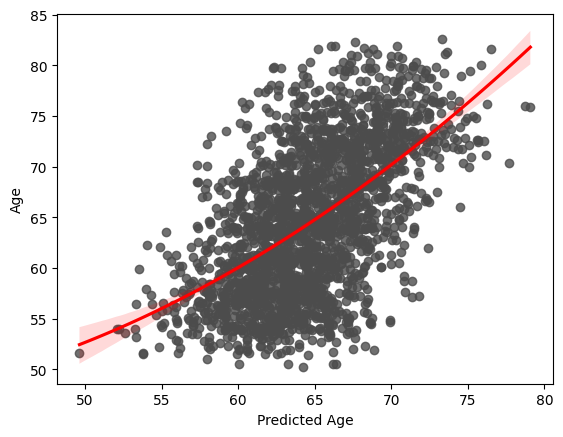

In [23]:
# predict from training data
pred_train = result.predict(x)
# make the plot
plot = seaborn.regplot(x=pred_train,y=y, ci=95, color=".3", line_kws=dict(color="r"), order = 2)
plot.set(xlabel="Predicted Age", ylabel="Age")


# Second for test data

[Text(0.5, 0, 'Predicted Age'), Text(0, 0.5, 'Age')]

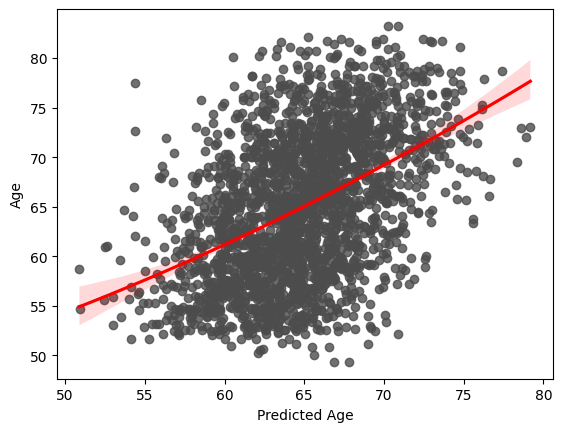

In [24]:
plot = seaborn.regplot(x=pred,y=Y, ci=95, color=".3", line_kws=dict(color="r"), order = 2)
plot.set(xlabel="Predicted Age", ylabel="Age")

In [26]:
print('Remember, these were the evalutation stats for training and testing predictions:')
print ('------------------------------\n')
RMSE = cross_val_score(lasso_model, x, y, cv=cv,scoring='neg_root_mean_squared_error',n_jobs = 4)
print ('Training Mean and STD for RMSE (in years): %.3f (%.3f)\n' % (mean(RMSE), std(RMSE)))
RMSE = root_mean_squared_error(Y,pred)
print ('Test RMSE (in years) = %.3f' % ((RMSE)))
print ('------------------------------\n')
MAE = cross_val_score(lasso_model, x, y, cv=cv,scoring='neg_mean_absolute_error',n_jobs = 4)
print('Training Mean and STD for MAE (in years): %.3f (%.3f)\n' % (mean(MAE), std(MAE)))
MAE = mean_absolute_error(Y,pred)
print ('Test MAE (in years) = %.3f' % ((MAE)))
print ('------------------------------\n')
R2 = cross_val_score(lasso_model, x, y, cv=cv,scoring='r2',n_jobs = 4)
print('Training Mean and STD for R2 (between 0 and 1): %.3f (%.3f)\n' % (mean(R2), std(R2)))
R2 = r2_score(Y,pred)
print ('Test R2 (0 to 1) = %.3f' % ((R2)))
print ('------------------------------\n')
print ('As expected, we can see a performance decrease from trainig to testing. Yet, this decrease can be much higher in other cases.')



Remember, these were the evalutation stats for training and testing predictions:
------------------------------

Training Mean and STD for RMSE (in years): -6.410 (0.282)

Test RMSE (in years) = 6.601
------------------------------

Training Mean and STD for MAE (in years): -5.174 (0.292)

Test MAE (in years) = 5.385
------------------------------

Training Mean and STD for R2 (between 0 and 1): 0.219 (0.044)

Test R2 (0 to 1) = 0.198
------------------------------

As expected, we can see a performance decrease from trainig to testing. Yet, this decrease can be much higher in other cases.


## You have successfully trained different models, made metrics-informed choices on the model selection, and predicted in unseen data. Well done!